In [2]:
# importing libraries

import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [6]:
# download the movie review dataset and store it in Keras's cache memory
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')
print(dataset)

84131840/84125825 [==============================] - 1s 0us/step
./aclImdb_v1


In [8]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
print(dataset_dir)

./aclImdb


In [9]:
# print the contents of the directory "aclImdb" directory
# dir stands for directory
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'train', 'test', 'README']

In [10]:
# print the contents of the "train" directory
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsupBow.feat',
 'urls_pos.txt',
 'neg',
 'labeledBow.feat',
 'urls_unsup.txt',
 'urls_neg.txt',
 'pos',
 'unsup']

In [12]:
# randomly select a file inside "pos" directory and print its content
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [15]:
# "text_dataset_from_directory" keras function - allows us to extract text data from a dataset 
"""
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
"""

# remove the "unsup" (unsupervised learning) directory tree (itself and its subdirectories)
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [16]:
# create a dataset object

batch_size = 32
seed = 42

# copy 80% of training samples to "raw_train_ds"
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)
print(len(raw_train_ds))

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
625


In [20]:
# take the first batch out of the 625 batches 
# print all 32 examples in that batch
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(32):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />There\'s a 

In [21]:
# print corresponding string names of integer classes 
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [23]:
# copy remaining 20% of training examples to "raw_val_ds" (validation split)
# same seed ensures no duplicates in both splits 
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)
print(len(raw_val_ds))

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
157


In [25]:
# copy all the test examples to "raw_test_ds" (test split)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [27]:
# define function for preprocessing text
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  # regex_replace(input, pattern, replace)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  # replace punctuations with empty string (ie. removing punctuations)
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [32]:
# define layer that will perform Vectorization
max_features = 10000 # max number of words
sequence_length = 250 # length set for each review

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [41]:
# Make a text-only dataset (without labels), then call adapt (i.e. fit)
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [42]:
def vectorize_text(text, label):
  # Add an innermost dimension for batch
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [43]:
# retrieve a batch (of 32 reviews and labels) from the dataset
# iter() makes it iterable, next() selects batch 0
text_batch, label_batch = next(iter(raw_train_ds))  
# select first review out of 32 reviews in batch 0
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"Emma" was a product of what might be called by the First Great Jane Austen Cycle of the mid-nineties, and it was recently shown on British television, doubtless because of the interest in the author created by the Second Great Jane Austen Cycle which started with "Pride and Prejudice" two years ago. We currently have in the cinemas the Austen biopic "Becoming Jane", and ITV have recently produced three TV movies based on Austen novels. These include "Northanger Abbey", the only one of the six major novels not to have been filmed previously, so the cycle should now be complete. No doubt, however, there will be more to come in the near future. (There is, after all, her juvenile "Love and Freindship" (sic), the short novella "Lady Susan", and someone, somewhere, has doubtless supplied endings to her two unfinished fragments "The Watsons" and "Sanditon". Then there are all those Austen sequels churned out by modern writers\xc2\x85\xc2\x85\xc2\x85).<br /><br />The main c

In [44]:
# Print tokens corresponding to indices
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [46]:
# apply function "vectorize_text" on all three splits
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [50]:
# optimize code by prefetching data in buffer
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [55]:
# defining the model architecture
embedding_dim = 16

In [52]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [54]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 13s 15ms/step - loss: 0.6654 - binary_accuracy: 0.6885 - val_loss: 0.6157 - val_binary_accuracy: 0.7708
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5490 - binary_accuracy: 0.7966 - val_loss: 0.4982 - val_binary_accuracy: 0.8220
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4452 - binary_accuracy: 0.8431 - val_loss: 0.4201 - val_binary_accuracy: 0.8474
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3787 - binary_accuracy: 0.8654 - val_loss: 0.3737 - val_binary_accuracy: 0.8606
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3363 - binary_accuracy: 0.8771 - val_loss: 0.3449 - val_binary_accuracy: 0.8662
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3054 - binary_accuracy: 0.8881 - val_loss: 0.3258 - val_binary_accuracy: 0.8720
Epoch 7/10
625/625 [==============================] - 4s 6ms/s

In [56]:
# evaluating the model
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 7s 9ms/step - loss: 0.3104 - binary_accuracy: 0.8732
Loss:  0.31037774682044983
Accuracy:  0.8731600046157837


In [57]:
# create a plot of accuracy and loss over time
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

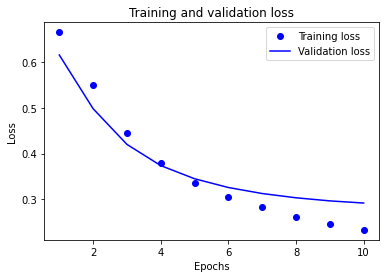

In [58]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

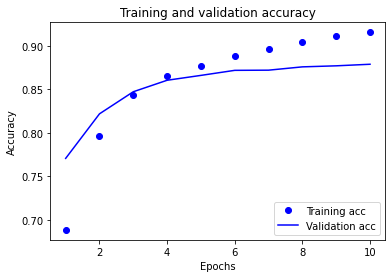

In [59]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [60]:
# export the model 
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3104 - accuracy: 0.8732
0.8731600046157837


In [61]:
# inference on new data
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.64154845],
       [0.46701565],
       [0.384455  ]], dtype=float32)